<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/Cell_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem:** Counting cells in microscopy images (regression).

**Dataset:** [BBBC Datasets](https://bbbc.broadinstitute.org/) - The BBBC datasets contain a useful collection of annotated bioimage datasets from various cellular assays. Specifically, we are going to use [BBBC005](https://bbbc.broadinstitute.org/BBBC005) - Synthetic cells ( the ground truth consists of the number of cells in each image, as counted by one or more humans).


**Why is this an interesting task?**
For a number of biological experiments, it can be quite useful to track the number of cells that survive after a given intervention. For example, perhaps the cells are drawn from a cancer cell line, and the intervention is the application of an anticancer compound. A successful intervention would reduce the number of living cancer cells,

## Setup

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import deepchem as dc
dc.__version__

## Loading dataset (BBBC005)

In [ ]:
# Downloading the dataset (about 2-5 minutes)
!wget https://data.broadinstitute.org/bbbc/BBBC005/BBBC005_v1_images.zip

--2021-07-14 03:59:51--  https://data.broadinstitute.org/bbbc/BBBC005/BBBC005_v1_images.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1882973059 (1.8G) [application/zip]
Saving to: ‘BBBC005_v1_images.zip’

BBBC005_v1_images.z 100%[===================>]   1.75G   769KB/s    in 76m 34s 

2021-07-14 05:16:26 (400 KB/s) - ‘BBBC005_v1_images.zip’ saved [1882973059/1882973059]



In [ ]:
!unzip BBBC005_v1_images.zip

### Loading the dataset into DeepChem

In [ ]:
import os
import re

import numpy as np

In [ ]:
image_dir = 'BBBC005_v1_images'
files = []
labels = []

for f in os.listdir(image_dir):
  if f.endswith('.TIF'):
    files.append(os.path.join(image_dir, f))
    # the label is explicit (# of cells) on name of image file
    labels.append(int(re.findall('_C(.*?)_', f)[0]))

dataset = dc.data.ImageDataset(files, np.array(labels))

In [ ]:
# Split the dataset
splitter = dc.splits.RandomSplitter()

train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
  dataset, seed=123
)

In [ ]:
train_dataset.get_shape()

(array([15360,   520,   696]), (15360,), (15360,), (15360,))

## Creating the model (CNN)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [ ]:
input_shape = (520, 696, 1)
batch_size = 64

optimizer = dc.models.optimizers.ExponentialDecay(initial_rate=0.001, decay_rate=0.9, decay_steps=250)

In [ ]:
input = tf.keras.Input(shape=input_shape)
cnn = input

for num_filters in [16, 32, 64, 128]:
  cnn = layers.Conv2D(filters=num_filters, kernel_size=5, strides=2, activation='relu')(cnn)
  cnn = layers.Dropout(rate=0.3)(cnn)

cnn = layers.MaxPool2D(pool_size=(2, 2))(cnn)

cnn = layers.Flatten()(cnn)
output = layers.Dense(units=1)(cnn)

keras_model = tf.keras.Model(inputs=input, outputs=output)

loss = dc.models.losses.L2Loss()

model = dc.models.KerasModel(
    model=keras_model,
    loss=loss,
    learning_rate=optimizer,
    batch_size=batch_size
)

## Training

Note: If you don't want to train the model, you can get a pre-trained model [here](https://s3-us-west-1.amazonaws.com/deepchem.io/featurized_datasets/microscopy_models.zip), and then load with `model.restore()` (you need to specify model directory when you instance the model).

You can use the next code in order to download the weights of the trained model:

```
mkdir models
cd models
wget https://s3-us-west-1.amazonaws.com/deepchem.io/featurized_datasets/microscopy_models.zip
unzip microscopy_models.zip
```



In [1]:
from tqdm.notebook import tqdm

In [ ]:
pearsonr2 = dc.metrics.Metric(metric=dc.metrics.pearson_r2_score, mode='regression')
num_epochs = 50

In [ ]:
train_pearsonr2 = []
valid_pearsonr2 = []

# Check performance using validation test every 10 epochs.

for x in tqdm(range(num_epochs // 10)):
  model.fit(train_dataset, nb_epoch=10)

  train_score = model.evaluate(dataset=train_dataset, metrics=[pearsonr2])
  valid_score = model.evaluate(dataset=valid_dataset, metrics=[pearsonr2])

  train_pearsonr2.append(train_score['pearson_r2_score'])
  valid_pearsonr2.append(valid_score['pearson_r2_score'])

## Results and testing

In [ ]:
print('Training dataset - pearson r2 score: {}'.format(train_pearsonr2[-1]))
print('Validation dataset - pearson r2 score: {}'.format(valid_pearsonr2[-1]))

Training dataset - pearson r2 score: 0.958656439857493
Validation dataset - pearson r2 score: 0.95421475262831


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

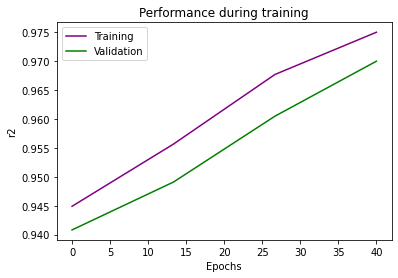

In [ ]:
x = np.linspace(0, num_epochs, num_epochs // 10)

plt.title('Performance during training')
plt.plot(x, train_pearsonr2, label='Training', color='purple')
plt.plot(x, valid_pearsonr2, label='Validation', color='green')

plt.xlabel('Epochs')
plt.ylabel('r2')

# plt.ylim(0.40, 1.0)

plt.legend()
plt.show()

In [ ]:
# test dataset
test_score = model.evaluate(dataset=test_dataset, metrics=[pearsonr2])
print('Test score: {}'.format(test_score))

Test score: {'pearson_r2_score': 0.9586807299449425}


**Note**: It's a good result. Another aproach could be using a object detection model if we had the cell located and labeled on the images.